In [1]:
import pandas as pd
import numpy as np
import random
import scipy
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)


<a id='ab'></a>
##  A/B тестирование

A/B-тестирование (англ. A/B testing, Split testing) — метод маркетингового исследования, суть которого заключается в том, что контрольная группа элементов сравнивается с набором тестовых групп, в которых один или несколько показателей были изменены, для того, чтобы выяснить, какие из изменений улучшают целевой показатель и улучшают ли.

Типичное применение в веб-дизайне — исследование влияния цветовой схемы, расположения и размера элементов интерфейса на конверсию сайта.

Конверсия (Conversion Rate) в интернет-маркетинге — это отношение числа посетителей сайта, выполнивших на нём какие-либо целевые действия (покупку, регистрацию, подписку, посещение определённой страницы сайта, переход по рекламной ссылке), к общему числу посетителей сайта, выраженное в процентах. 



В теории принципы A/B тестирования невероятно просты:

- Выдвигаем предположение о том, что какое-то изменение (например, персонализация главной страницы) увеличит конверсию интернет-магазина.

- Создаем альтернативную версию сайта «Б» — копию исходной версии «А» с изменениями, от которых мы ждем роста эффективности сайта.

- Всех посетителей сайта случайным образом делим на две равные группы: одной группе показываем исходный вариант (контрольная группа) , второй группе (тестовой) — альтернативный. Одновременно измеряем конверсию для обеих версий сайта.

- Определяем статистически достоверно победивший вариант.

Мы будем анализировать результаты A/B тестирования двух версий дизайна кнопки сайта интернет-магазина. 

Целевым действием считаем клик по этой кнопке. 

Первые три этапа А/В тестирования за нас провели, результаты предоставили в виде файла ab_dataset.csv. Нам осталось выполнить четвертый пункт.

**Задание **

Провести аналогичные исследования но для чека покупок клиентов (колонки `revenue`)  
в интернет магазине есть 2-ва типа продуктов:
* 100 руб.
* 250 руб.

ну и конечно клиент может ничего не купить  
провести исследование изменился ли средний чек

 <a id='eda'></a>
### Первичный анализ данных

Прочитаем данные из файла `ab_datas.csv`. Сохраним их в датафрейм `df`. 

Прочитаем данные и посмотрим на первые 5 строк:

In [2]:
df = pd.read_csv('ab_datas.csv')

df.head()

,user_id,timestamp,group,landing_page,converted,revenue
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,100
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,250


Посмотрим, сколько посетителей заходио на сайт (количество строк в нашем датафрейме)

In [3]:
#количество посетителей всего

n_rows = df.shape[0]
print("Число строк: {}".format(n_rows))

Число строк: 294478


Сколько уникальных пользователей (уникальных `user_id`) в датасете?

In [4]:
user_total = df.nunique()['user_id']
print("Число уникальных пользователей : {}".format(user_total))

Число уникальных пользователей : 290584


Посетителей из контрольной `control` группы должны были направлять на страницу в старом дизайне  `old_page` , пользователей из тестовой группы `treatment` - на страницу в новом дизайне `new_page`. Проверим, были ли ошибки при направлении.

In [5]:
mismatch_1 = df.query("group == 'treatment' and landing_page == 'old_page'")
print("Из тестовой группы неверно направлены {}".format(len(mismatch_1)) + " пользователей")

mismatch_2 = df.query("group == 'control' and landing_page == 'new_page'")
print("Из контрольной группы неверно направлены  {}".format(len(mismatch_2)) + " пользователей")


Из тестовой группы неверно направлены 1965 пользователей
Из контрольной группы неверно направлены  1928 пользователей


Выясним, есть ли в данных пропуски.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
 5   revenue       294478 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 13.5+ MB


Из сообщений следует, что пропущенных значений нет.

Конверсия по всем посетителям

In [10]:
p_all=df['revenue'].mean()
p_all_buy=df['revenue'][df['revenue'] != 0].mean()
print(f"Средний чек по всем посетителям: {p_all:.2f}")
print(f"Средний чек по всем купившим посетителям: {p_all_buy:.2f}")

Средний чек по всем посетителям: 101.97
Средний чек по всем купившим посетителям: 175.11


In [30]:
print(f'Общая доля пользователей, совершивших покупки: {df[df["revenue"] == 0].shape[0]/df.shape[0]*100}%')

df_control = df[df['group'] == 'control']
df_test = df[df['group'] == 'treatment']

print(f'Доля пользователей контролькой группы, совершивших покупки: {df_control[df_control["revenue"] == 0].shape[0]/df_control.shape[0]*100}%')

print(f'Доля пользователей тестовой группы, совершивших покупки: {df_test[df_test["revenue"] == 0].shape[0]/df_test.shape[0]*100}%')

Общая доля пользователей, совершивших покупки: 41.76882483581117%
Доля пользователей контролькой группы, совершивших покупки: 50.135867719188596%
Доля пользователей тестовой группы, совершивших покупки: 33.4059860398164%


Давайте посмотрим на описательную статистику нашего датасета (воспользуемся функцией  `describe`) и постараемся получить ответ на вопрос какой средний чек по группам пользователей?

In [22]:
df_grp = df.groupby('group')
df_grp['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,147202.0,87.431896,102.424926,0.0,0.0,0.0,250.0,250.0
treatment,147276.0,116.496238,102.732069,0.0,0.0,100.0,250.0,250.0


In [31]:
df_grp['revenue'].sum()

group
control      12870150
treatment    17157100
Name: revenue, dtype: int64

Можем сделать следующие выводы:
- у пользователей контрольной группы средний чек - 87.43, у тестовой - 116.496; 
- процент пользователей, совершивших покупки у тестовой группы (33.4%) меньше, чем у контрольной (50.13%);
- общий чек по всем пользователям группы больше у тестовой группы (17 157 100 против 12 870 150 - сравнение допустимо с учетом равенства групп).

<a id='si1'></a>
#### Формулировка рабочей гипотезы

Рабочая гипотеза в нашем случае может быть сформулирована, например, так: "Средний чек для пользователя сайта со старым дизайном не меньше, чем с новым"

<a id='si2'></a>
#### Формальное описание нулевой и альтернативной гипотез

$H_{0}$ : $\theta_{new}$ <= $\theta_{old}$ 

$H_{1}$ : $\theta_{new}$ > $\theta_{old}$ 

<a id='si1'></a>
#### Выбор подходящего статистического теста (статистического критерия)

Истинные значения $\theta_{new}$ и $\theta_{old}$ мы найти не можем, но мы можем их сравнить. В этом помогут те самые две теоремы.






На основании Закона больших чисел мы можем оценить средние значения случайных величин $\theta_{new}$ и $\theta_{old}$ на  генеральных совокупностях по их средним значениям на наших больших выборках.

На основании Центральной предельной теоремы средние значения распределены нормально при больших объемах выборок.

Чтобы выбрать для проверки наших гипотез подходящий статистический критерий, уясним задачу. Нам нужно выяснить, случайно или значимо отличаются средние значения выручки в контрольной и тестовой выборках.

#### Мы не знаем истинную дисперсию наших выборок, поэтому применим $T$-тест.

In [74]:
t_score, p_value, _ = statsmodels.stats.weightstats.ttest_ind(df_test['revenue'], 
                                                              df_control['revenue'],
                                                              alternative="larger",
                                                              usevar='unequal')

In [75]:
print("T-статистика={},  p_value={}".format(t_score, p_value))

T-статистика=76.8776779597561,  p_value=0.0


#### Проведение вычислений. $Mann–Whitney$-test.

In [78]:
w_score, p_value = scipy.stats.mannwhitneyu(df_test['revenue'], df_control['revenue'], alternative="greater")

In [79]:
print("W-статистика={},  p_value={}".format(w_score, p_value))

W-статистика=12643398633.5,  p_value=0.0


**Значения p-value в обоих случаях близки к 0, поэтому нулевая гипотеза опровергнута - средний чек в новой версии сайта больше.**

## bootstrap  
Сделаем стат выводы при помощи bootstrap-а

In [80]:
df.head()

,user_id,timestamp,group,landing_page,converted,revenue
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,100
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,250


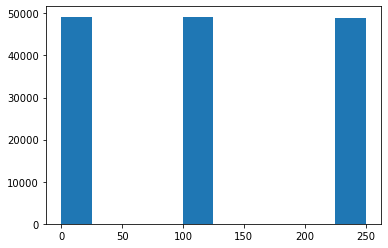

In [81]:
plt.hist(df.loc[df['group']=='treatment', 'revenue'])

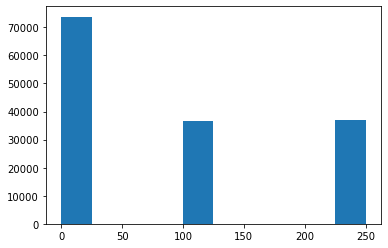

In [82]:
plt.hist(df.loc[df['group']=='control', 'revenue']);

In [83]:
b = df.loc[df['group']=='treatment', 'revenue'].values
a = df.loc[df['group']=='control', 'revenue'].values

In [84]:
from sklearn.utils import resample

a_means = []
b_means = []

for i in range(10000):
    a_boot = resample(a, replace=True, n_samples=len(a))
    b_boot = resample(b, replace=True, n_samples=len(b))
    
    a_means.append(a_boot.mean())
    b_means.append(b_boot.mean())
    
a_means = np.array(a_means)
b_means = np.array(b_means)

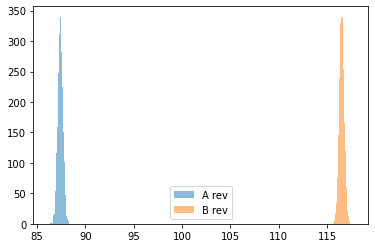

In [85]:
plt.hist(a_means, label='A rev', alpha=0.5, bins=100)
plt.hist(b_means, label='B rev', alpha=0.5, bins=100)

plt.legend()
plt.show()

In [86]:
# доверительный интервал
np.percentile(a_means, 2.5), np.percentile(a_means, 97.5)

(86.9148686838494, 87.95975088653687)

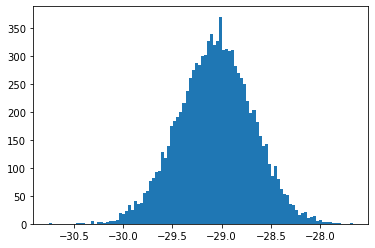

In [87]:
plt.hist(a_means - b_means, bins=100)
plt.show()

In [88]:
# сделаем оценку на p_value
dff = a_means - b_means

len(dff[dff>=0])/len(dff)

0.0

Выводы подтверждаются